Importando as bibliotecas necessárias para o projeto

In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

import tensorflow as tf
import random
from cv2 import resize
from glob import glob

import warnings
warnings.filterwarnings("ignore")

Definindo dimensões padrão para redimensionar as imagens.

Carregando o conjunto de treinamento e validação a partir do diretório de imagens:
- 20% dos dados são reservados para validação.
- Imagens redimensionadas para 244x244 pixels.
- Dados divididos em lotes de 32 imagens.
- O shuffle é aplicado para aumentar a robustez do modelo.
- Seed aleatória definida para garantir resultados reprodutíveis.

Banco utilizado: https://www.kaggle.com/datasets/pythonafroz/solar-panel-images

In [33]:
img_height = 244
img_width = 244
train_ds = tf.keras.utils.image_dataset_from_directory(
  r'C:\Users\lufau\Downloads\Faulty_solar_panel',
  validation_split=0.2,
  subset='training',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  r'C:\Users\lufau\Downloads\Faulty_solar_panel',
  validation_split=0.2,
  subset='validation',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

Found 885 files belonging to 6 classes.
Using 708 files for training.
Found 885 files belonging to 6 classes.
Using 177 files for validation.


Imprimindo os nomes das classes no conjunto de treinamento e exibindo informações desse conjunto.

In [34]:
class_names = train_ds.class_names
print(class_names)
train_ds

['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Exibindo algumas imagens do lote de treinamento

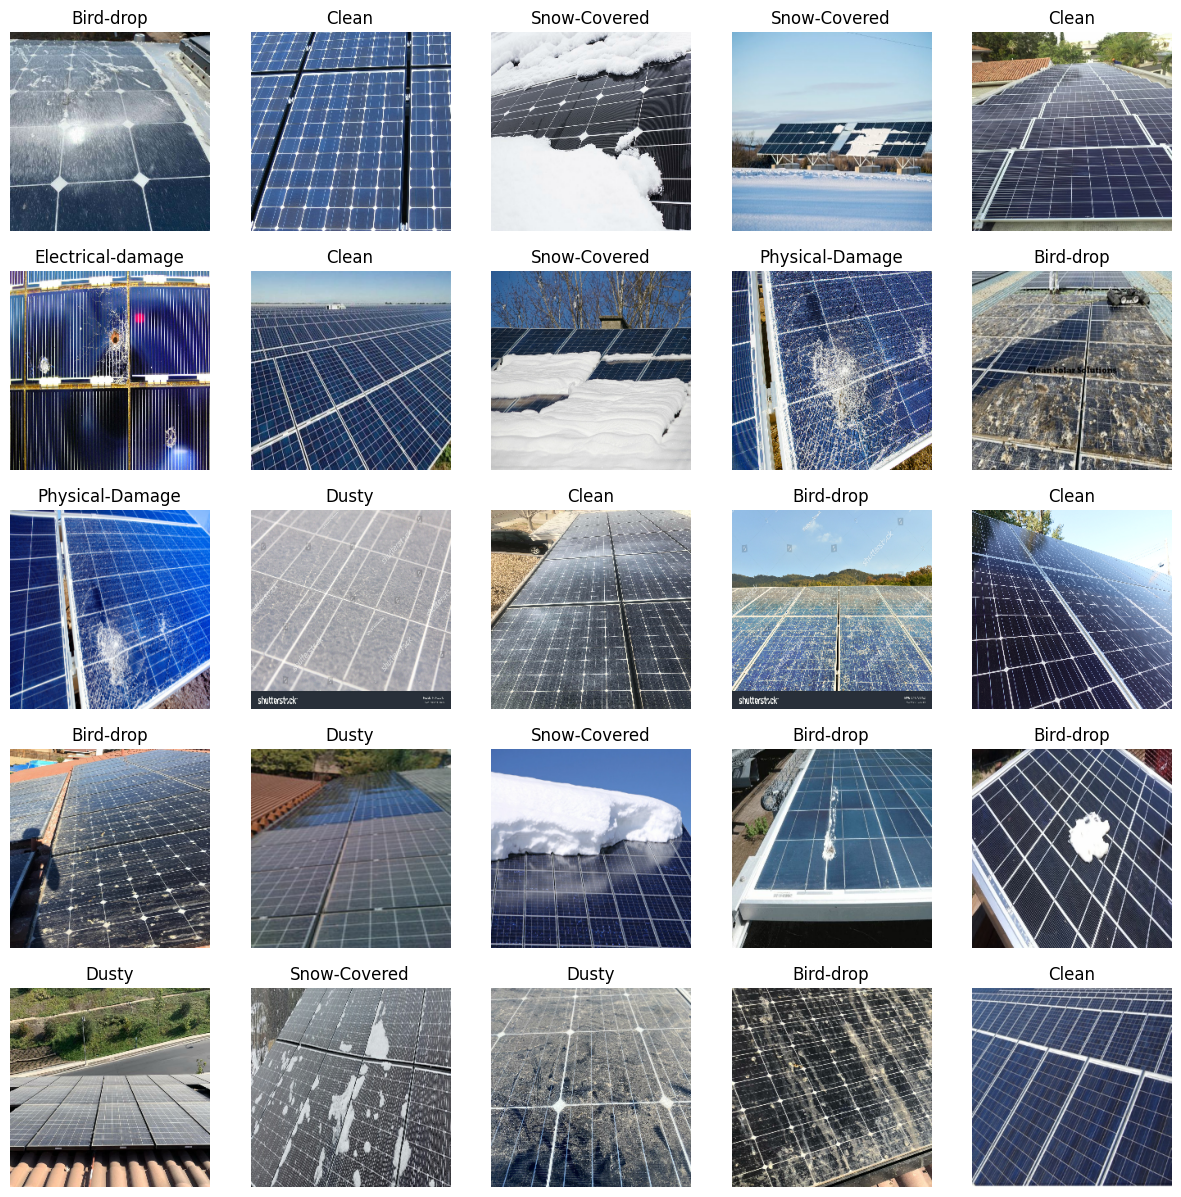

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Carregando o modelo pré-treinado VGG16

In [36]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False 

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Construção do modelo personalizado usando o VGG16 como base

In [37]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(90)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 244, 244)  │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 244, 244)  │          0 │ input_layer_7[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 244, 244)  │          0 │ input_layer_7[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 244, 244,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 244, 244,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 512)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 90)        │     46,170 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,760,858 (56.31 MB)

 Trainable params: 46,170 (180.35 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Configurando o modelo para treinamento

In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Aqui realizamos o treinamento do modelo e configuramos para interromper caso não haja melhorias significativas em 3 epochs consecutivas.

In [44]:
epoch = 15
model.fit(train_ds, validation_data=val_ds, epochs=epoch,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=3,
            verbose=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.0854 - loss: 12.2067 - val_accuracy: 0.3277 - val_loss: 3.5088
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.3012 - loss: 4.9677 - val_accuracy: 0.4520 - val_loss: 2.3593
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.4102 - loss: 3.1917 - val_accuracy: 0.5028 - val_loss: 1.7832
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.4662 - loss: 2.5548 - val_accuracy: 0.5763 - val_loss: 1.5703
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.5438 - loss: 2.1283 - val_accuracy: 0.6045 - val_loss: 1.4456
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.5899 - loss: 1.6696 - val_accuracy: 0.6271 - val_loss: 1.3046
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.6342 - loss: 1.4159 - val_accuracy: 0.6328 - val_loss: 1.2716
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.6470 - loss: 1.3922 - val_accuracy: 0.6667 - val_loss

Começamos o fine-tuning, permitindo que camadas profundas do modelo base sejam ajustadas para os dados do nosso modelo personalizado

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:14]:
    layer.trainable = False
model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 244, 244)  │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 244, 244)  │          0 │ input_layer_7[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 244, 244)  │          0 │ input_layer_7[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 244, 244,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 244, 244,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 512)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 90)        │     46,170 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,853,200 (56.66 MB)

 Trainable params: 7,125,594 (27.18 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 92,342 (360.71 KB)

Recompilação do modelo após o fine-tuning

In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Treinamento do modelo após a recompilação, obtendo uma acurácia de 99%

In [ ]:
epoch = 15
history = model.fit(train_ds, validation_data=val_ds, epochs=epoch,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=3,
            verbose=1,
        )
    ]
)

Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.6446 - loss: 1.2604 - val_accuracy: 0.7458 - val_loss: 0.9530
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.7963 - loss: 0.6460 - val_accuracy: 0.7910 - val_loss: 0.7170
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.9037 - loss: 0.2682 - val_accuracy: 0.8136 - val_loss: 0.6729
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.9458 - loss: 0.1764 - val_accuracy: 0.7910 - val_loss: 0.6666
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.9719 - loss: 0.1085 - val_accuracy: 0.8192 - val_loss: 0.7586
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.9839 - loss: 0.0802 - val_accuracy: 0.7853 - val_loss: 0.6523
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.9696 - loss: 0.1034 - val_accuracy: 0.8305 - val_loss: 0.7455
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.9787 - loss: 0.0661 - val_accuracy: 0.8531 - val_loss

Aqui mostramos exemplos reais para prever o desempenho qualitativo do modelo.

6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8673 - loss: 0.6854
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


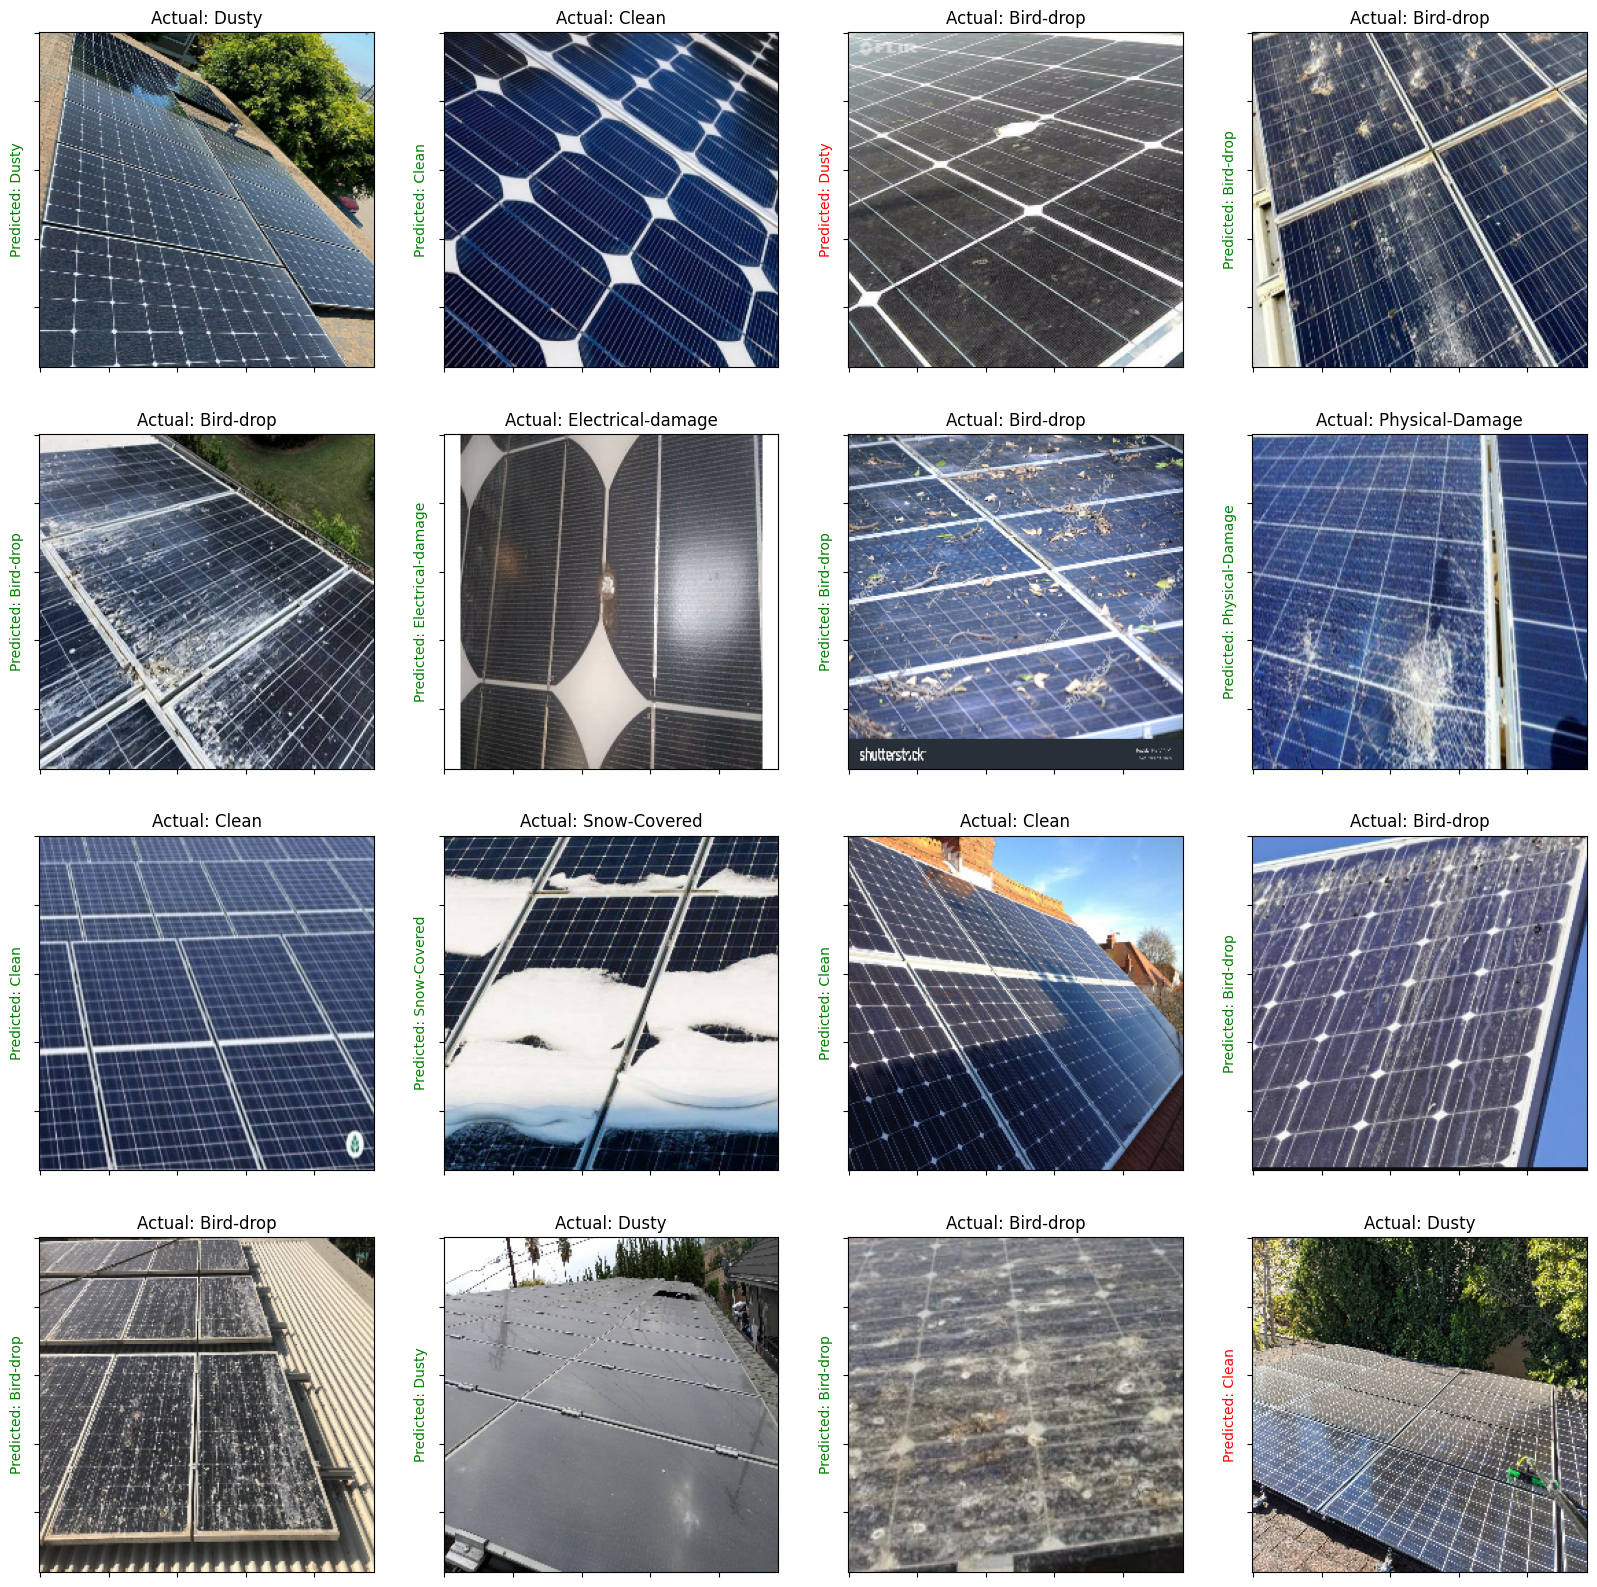

In [48]:
loss, accuracy = model.evaluate(val_ds)

plt.figure(figsize=(20, 20))
for images, labels in val_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])